# CLUSTERING

 ## I.Mục tiêu

1. Tạo bộ đặc trưng (features) theo từng quốc gia từ dữ liệu COVID-19 dạng chuỗi thời gian.

2. Chuẩn hóa dữ liệu và giảm chiều (PCA) để hỗ trợ trực quan và phân cụm.

3. Huấn luyện và so sánh 3 thuật toán phân cụm: KMeans, GMM, DBSCAN.

4. Đánh giá chất lượng cụm bằng Silhouette, Davies–Bouldin, Calinski–Harabasz.

5. Lưu kết quả và biểu đồ:

    - CSV vào data/3_model

    - Hình vào output/model_results

## II.Import thư viện

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os

## III.Cấu hình đường dẫn

In [29]:
# Input
INPUT_FILE = "../data/3_model/covid19_feature_engineered.csv"

# Output CSV (giữ nguyên)
OUTPUT_CSV_DIR = "../data/3_model"
os.makedirs(OUTPUT_CSV_DIR, exist_ok=True)

# Output hình ảnh
OUTPUT_IMG_DIR = "../output/model_results"
os.makedirs(OUTPUT_IMG_DIR, exist_ok=True)

print("CSV sẽ lưu tại:", OUTPUT_CSV_DIR)
print("Hình ảnh sẽ lưu tại:", OUTPUT_IMG_DIR)


CSV sẽ lưu tại: ../data/3_model
Hình ảnh sẽ lưu tại: ../output/model_results


## IV.Load dữ liệu

In [30]:
df = pd.read_csv(INPUT_FILE)
df.head()

,Country/Region,Date,Confirmed,Deaths,Recovered,New_Cases,New_Deaths,MA7_New_Cases,Mortality_Rate
0,Afghanistan,2020-01-22,0,0,0,0.0,0.0,0.0,0.0
1,Afghanistan,2020-01-23,0,0,0,0.0,0.0,0.0,0.0
2,Afghanistan,2020-01-24,0,0,0,0.0,0.0,0.0,0.0
3,Afghanistan,2020-01-25,0,0,0,0.0,0.0,0.0,0.0
4,Afghanistan,2020-01-26,0,0,0,0.0,0.0,0.0,0.0


## V.Chọn feature để clustering

In [31]:
features = [
    "Confirmed", "Deaths", "Recovered",
    "New_Cases", "New_Deaths",
    "MA7_New_Cases", "Mortality_Rate"
]

df_features = df.groupby("Country/Region")[features].max().reset_index()
df_features.head()

,Country/Region,Confirmed,Deaths,Recovered,New_Cases,New_Deaths,MA7_New_Cases,Mortality_Rate
0,Afghanistan,209451,7896,82586,3243.0,159.0,2095.571429,0.046613
1,Albania,334457,3598,130314,4789.0,21.0,2290.714286,0.083333
2,Algeria,271496,6881,118409,2521.0,49.0,2177.571429,0.157842
3,Andorra,47890,165,14380,2313.0,7.0,734.285714,0.067017
4,Angola,105288,1933,39582,5035.0,30.0,1716.000000,0.285714


## VI.Tìm số cụm tối ưu (Elbow Method)

In [47]:
K_range = range(2, 10)
sse = []

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    sse.append(model.inertia_)

## VII.Vẽ Elbow Method

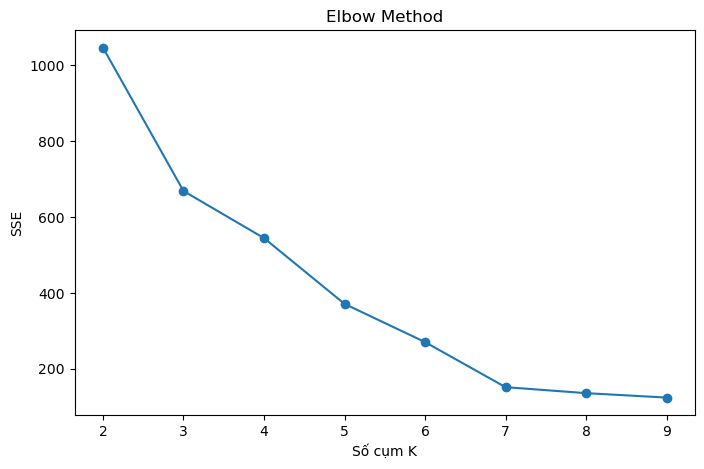

In [35]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(K_range, sse, marker='o')
ax.set_title("Elbow Method")
ax.set_xlabel("Số cụm K")
ax.set_ylabel("SSE")

fig.savefig(os.path.join(OUTPUT_IMG_DIR, "kmeans_elbow_method.png"))
plt.show()

## VIII.Tính Silhouette Score

In [36]:
sil_scores = []

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X)
    sil_scores.append(silhouette_score(X, labels))

## IX.Vẽ Silhouette Scores

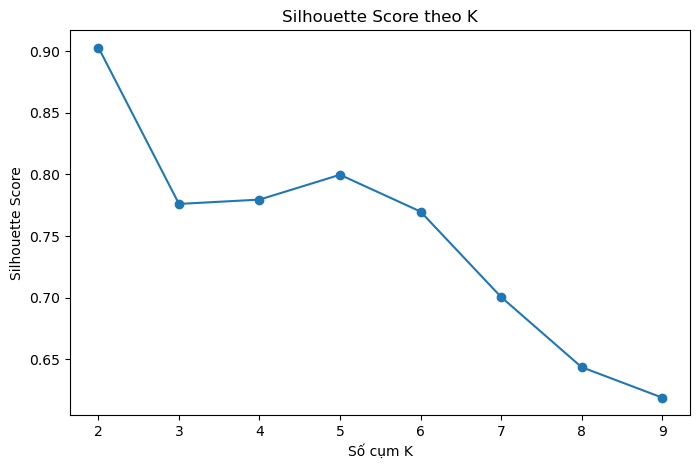

In [37]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(K_range, sil_scores, marker='o')
ax.set_title("Silhouette Score theo K")
ax.set_xlabel("Số cụm K")
ax.set_ylabel("Silhouette Score")

fig.savefig(os.path.join(OUTPUT_IMG_DIR, "kmeans_silhouette_scores.png"))
plt.show()

## X.Chọn số cụm tối ưu K

In [38]:
best_k = K_range[np.argmax(sil_scores)]
print("Số cụm tối ưu:", best_k)

Số cụm tối ưu: 2


## XI.Chạy KMeans

In [39]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
df_features["Cluster"] = kmeans.fit_predict(X)
df_features.head()

,Country/Region,Confirmed,Deaths,Recovered,New_Cases,New_Deaths,MA7_New_Cases,Mortality_Rate,Cluster
0,Afghanistan,209451,7896,82586,3243.0,159.0,2095.571429,0.046613,0
1,Albania,334457,3598,130314,4789.0,21.0,2290.714286,0.083333,0
2,Algeria,271496,6881,118409,2521.0,49.0,2177.571429,0.157842,0
3,Andorra,47890,165,14380,2313.0,7.0,734.285714,0.067017,0
4,Angola,105288,1933,39582,5035.0,30.0,1716.000000,0.285714,0


## XII.PCA để giảm chiều xuống 2D

In [40]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

df_features["PC1"] = pca_result[:,0]
df_features["PC2"] = pca_result[:,1]

## XIII.Vẽ scatter PCA

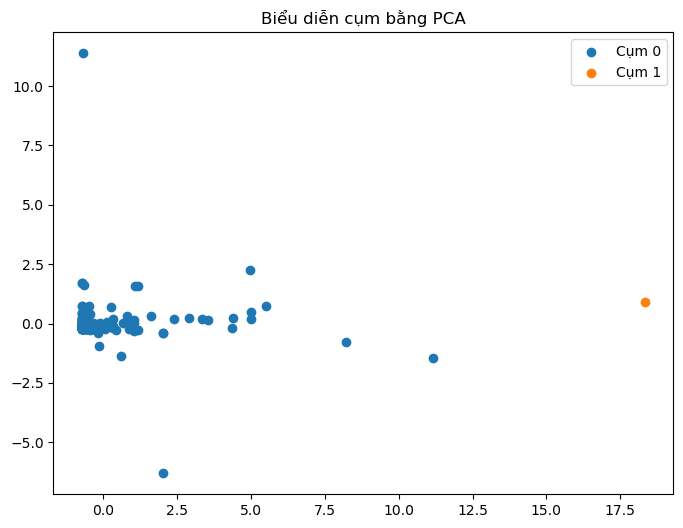

In [41]:
fig, ax = plt.subplots(figsize=(8,6))

for c in df_features["Cluster"].unique():
    subset = df_features[df_features["Cluster"] == c]
    ax.scatter(subset["PC1"], subset["PC2"], label=f"Cụm {c}")

ax.set_title("Biểu diễn cụm bằng PCA")
ax.legend()

fig.savefig(os.path.join(OUTPUT_IMG_DIR, "cluster_scatter_pca.png"))
plt.show()

## XIV.t-SNE visualization

In [43]:
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
tsne_result = tsne.fit_transform(X)

df_features["TSNE1"] = tsne_result[:,0]
df_features["TSNE2"] = tsne_result[:,1]

## XV.Vẽ scatter t-SNE

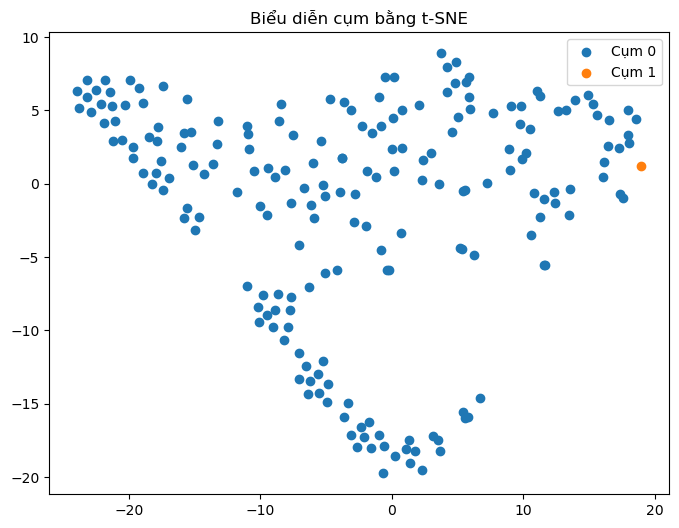

In [44]:
fig, ax = plt.subplots(figsize=(8,6))

for c in df_features["Cluster"].unique():
    subset = df_features[df_features["Cluster"] == c]
    ax.scatter(subset["TSNE1"], subset["TSNE2"], label=f"Cụm {c}")

ax.set_title("Biểu diễn cụm bằng t-SNE")
ax.legend()

fig.savefig(os.path.join(OUTPUT_IMG_DIR, "cluster_scatter_tsne.png"))
plt.show()


## XVI.Lưu file CSV

In [46]:
csv_path = os.path.join(OUTPUT_CSV_DIR, "covid19_clustered.csv")
df_features.to_csv(csv_path, index=False)

print("Đã lưu CSV:", csv_path)

Đã lưu CSV: ../data/3_model\covid19_clustered.csv
